In [80]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from systems.provided.example.simplesystem import simplesystem
from ctse.systems.ct_system import ct_system
import pandas as pd
import matplotlib.pyplot as plt

system = ct_system()
rawdata = system.rawdata
data = system.data

2022-11-07 18:01:40 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2022-11-07 18:01:40 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)


In [42]:
adjust_price  = data.daily_prices("A")
contract_price = rawdata.daily_denominator_price("A")
daily_returns = adjust_price.diff() / contract_price

In [43]:
# from sysquant.estimators.vol import simple_ewvol_calc


# adjust_price  = data.daily_prices("SP500")
# contract_price = rawdata.daily_denominator_price("SP500")
# daily_returns = adjust_price.diff() / contract_price
# vol = daily_returns.rolling(30).std().rename('vol')
# next_month_return = ((adjust_price.shift(-21) - adjust_price) / contract_price).rename('next_month_return')
# next_month_vol = daily_returns.shift(-21).rolling(21).std().rename('next_month_vol')

# pd.concat([vol, next_month_return], axis=1).sort_values('vol').plot.scatter(x='vol', y='next_month_return')


In [44]:
# import numpy as np

# df = pd.concat([vol, next_month_vol], axis=1)
# np.array_split(daily_returns, 5)[-1].tail(50)
# # .plot.scatter(x='vol', y='next_month_vol')

In [76]:
sector = system.data.all_instruments_in_asset_class('Black')

perc_returns = [rawdata.get_daily_percentage_returns(instrument_code).rename(instrument_code) for instrument_code in sector]
perc_returns_df = pd.concat(perc_returns, axis=1)
# use_returns =  perc_returns_df.resample("5B").sum()
use_returns = perc_returns_df

def get_forecast_and_future_corr(Nweeks_back, Nweeks_forward):
    forecast = get_historic_correlations(Nweeks_back)
    future = get_future_correlations(Nweeks_forward)

    pd_result = merge_forecast_and_future(forecast, future, Nweeks_forward)

    return pd_result

def merge_forecast_and_future(forecast, future, Nweeks_forward):
    assets = forecast.columns # should be the same won't check
    pd_result = []
    for asset in assets:
        result_for_asset = pd.concat([forecast[asset], future[asset]], axis=1)
        # remove tail with nothing
        result_for_asset = result_for_asset[:-Nweeks_forward]

        # remove overlapping periods which bias R^2
        selector = range(0, len(result_for_asset.index), Nweeks_forward)
        result_for_asset = result_for_asset.iloc[selector]

        result_for_asset.columns = ['forecast', 'turnout']
        pd_result.append(result_for_asset)

    pd_result = pd.concat(pd_result, axis=0)

    return pd_result

def get_future_correlations(Nweeks_forward):
    corr = get_rolling_correlations(use_returns, Nweeks_forward)
    corr = corr.ffill()
    future_corr = corr.shift(-Nweeks_forward)

    return future_corr

def get_historic_correlations(Nweeks_back):
    corr = get_rolling_correlations(use_returns, Nweeks_back)
    corr = corr.ffill()

    return corr

def get_rolling_correlations(use_returns, Nperiods, perm_names=None):
    roll_df = use_returns.rolling(Nperiods, min_periods=4).corr()
    if perm_names is None:
        perm_names = get_asset_perm_names(use_returns)
    roll_list = [get_rolling_corr_for_perm_pair(perm_pair, roll_df) for perm_pair in perm_names]
    roll_list_df = pd.concat(roll_list, axis=1)
    roll_list_df.columns = ["%s/%s" % (asset1, asset2) for (asset1, asset2) in perm_names]

    return roll_list_df

def get_asset_perm_names(use_returns):
    asset_names = use_returns.columns
    permlist = []
    for asset1 in asset_names:
        for asset2 in asset_names:
            if asset1==asset2:
                continue
            pairing = [asset1, asset2]
            if pairing in permlist:
                continue
            pairing.reverse()
            if pairing in permlist:
                continue

            permlist.append(pairing)

    return permlist

def get_interclass_asset_perm_names(asset_names, other_asset_names):
    permlist = []
    for asset1 in asset_names:
        for asset2 in other_asset_names:
            if asset1==asset2:
                continue
            pairing = [asset1, asset2]
            if pairing in permlist:
                continue
            pairing.reverse()
            if pairing in permlist:
                continue

            permlist.append(pairing)

    return permlist

def get_rolling_corr_for_perm_pair(perm_pair, roll_df):
    return roll_df[perm_pair[0]][:,perm_pair[1]]

rolling_correlations = get_rolling_correlations(use_returns, 52).dropna()

<AxesSubplot: xlabel='index'>

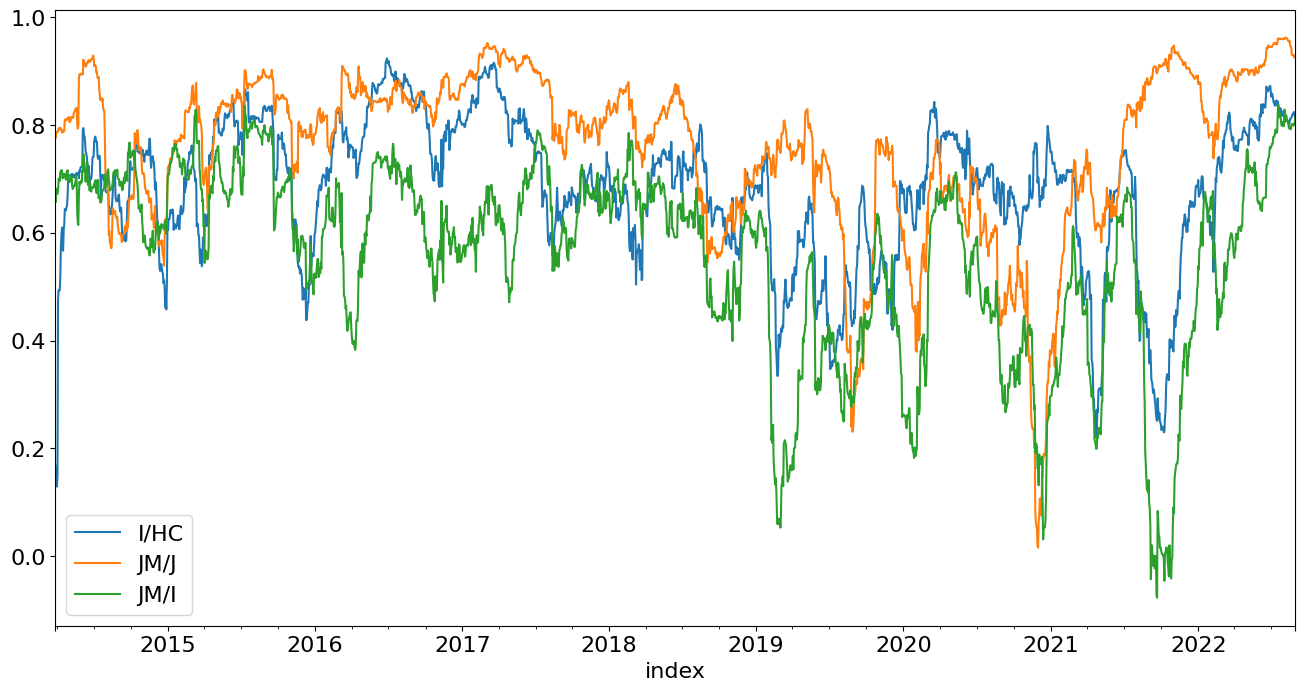

In [46]:
rolling_correlations.sample(3, axis=1).plot(figsize=(16,8))

4
7
13
26
52
104
208
520
1040


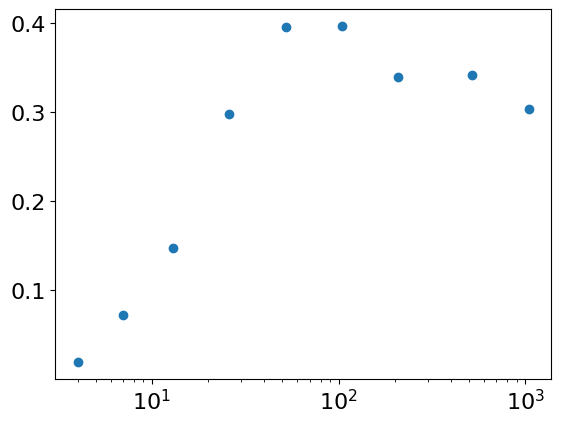

In [47]:
Nweeks_forward = 52 # use 13 weeks for underlying returns, 52 for others

import statsmodels.api as sm
import matplotlib.pyplot as pyplot
pyplot.rcParams.update({'font.size': 16})

Nweeks_list = [4, 7, 13, 26,52, 104, 208, 520, 520 * 2]
r_squared = []
for Nweeks_back in Nweeks_list:
    print(Nweeks_back)
    pd_result = get_forecast_and_future_corr(Nweeks_back, Nweeks_forward)

    pd_result = pd_result.dropna()

    x = pd_result.forecast
    x = sm.add_constant(x)
    y = pd_result.turnout
    est = sm.OLS(y, x).fit()
    r2 = est.rsquared_adj
    r_squared.append(r2)

ax = pyplot.gca()
ax.scatter(Nweeks_list, r_squared)
ax.set_xscale('log')

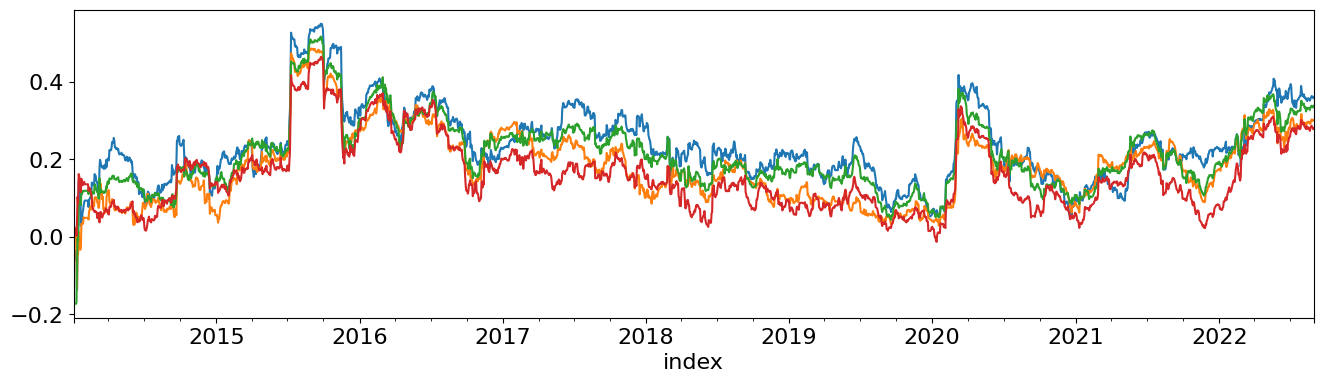

<AxesSubplot: xlabel='index'>

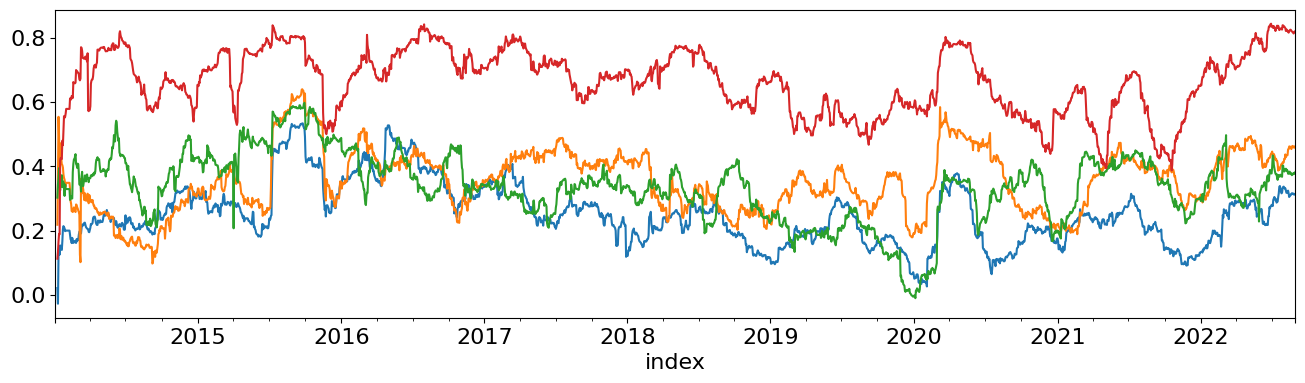

In [82]:
a = system.data.all_instruments_in_asset_class('Black')
b = system.data.all_instruments_in_asset_class('Metals')
c = system.data.all_instruments_in_asset_class('Chems')
d = system.data.all_instruments_in_asset_class('Ags')


perc_returns = [rawdata.get_daily_percentage_returns(instrument_code).rename(instrument_code) for instrument_code in system.get_instrument_list()]
perc_returns_df = pd.concat(perc_returns, axis=1)
# use_returns =  perc_returns_df.resample("5B").sum()
use_returns = perc_returns_df

pnames = get_interclass_asset_perm_names(a, b + c + d)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(b, a + c + d)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(c, b + a + d)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(d, b + c + a)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

plt.show()

pnames = get_interclass_asset_perm_names(d, d)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(c, c)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(b, b)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(a, a)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))